In [22]:

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
import warnings
warnings.filterwarnings("ignore")


In [3]:
''' 
Open-source dataset: LINCS MCF 10A Common Project: 
Fixed-time-point sensitivity measures of the MCF 10A breast cell line to 8 small molecule perturbagens.
Info: https://lincs.hms.harvard.edu/db/datasets/20363/main
Raw data: https://www.synapse.org/#!Synapse:syn18456352
'''

data = pd.read_csv('Individual_DR_sigmoid/GRvalues_center1_scientistC.csv')

In [7]:
data = data.sort_values(by=['agent'], ascending = [True]) 
agents = data.agent.unique()
col = sns.color_palette("hls", len(data.agent.unique())) 
colors = {agents[i]: col[i] for i in range(len(agents))} 
colors

{'Alpelisib/BYL719': (0.86, 0.3712, 0.33999999999999997),
 'Dasatinib': (0.86, 0.7612000000000001, 0.33999999999999997),
 'Etoposide': (0.5688000000000001, 0.86, 0.33999999999999997),
 'Neratinib/HKI272': (0.33999999999999997, 0.86, 0.5012000000000001),
 'Paclitaxel': (0.33999999999999997, 0.8287999999999999, 0.86),
 'Palbociclib/PD0332991': (0.33999999999999997, 0.43879999999999986, 0.86),
 'Trametinib/GSK1120212': (0.6311999999999998, 0.33999999999999997, 0.86),
 'Vorinostat': (0.86, 0.33999999999999997, 0.6987999999999996)}

In [33]:
'''
GraphPad prism equation 
https://www.graphpad.com/guides/prism/latest/curve-fitting/reg_dr_inhibit_variable_2.htm
Y=Bottom + (Top-Bottom)/(1+(IC50/X)^HillSlope)
- b: HillSlope
- c: Bottom 
- d: Top 
- e: IC50

'''

def ll4(x,b,c,d,e):
    return(c + (d-c) / (1+(e/x)**b))

In [46]:
#clean data by removing SM with weak DR
drop_list = ['Alpelisib/BYL719']
data_clean = data[~data['agent'].isin(drop_list)]

In [44]:
agents = data_clean.agent.unique()
SM_data = data_clean.groupby(['agent']) 
fitData = []
for name,group in SM_data:
    fitCoefs, covMatrix = opt.curve_fit(ll4, group.concentration, group.GRvalue) 
    resids = group.GRvalue-group.concentration.apply(lambda x: ll4(x,*fitCoefs)) 
    curFit = dict(zip(['b','c','d','e'],fitCoefs))
    curFit['agent']=name
    curFit['residuals']=sum(resids**2)
    fitData.append(curFit)
fit_SM = [item['agent'] for item in fitData]

fitTable = pd.DataFrame(fitData).set_index('agent') 
fitTable

,b,c,d,e,residuals
agent,,,,,
Dasatinib,0.511849,1.007519,-0.592162,3.166260,0.345058
Etoposide,1.444780,0.979912,-0.070749,0.325435,0.197319
Neratinib/HKI272,1.026972,1.027262,0.100285,0.078166,0.372204
Paclitaxel,1.830467,0.998479,-0.118883,0.003022,0.365944
Palbociclib/PD0332991,0.495370,1.039802,0.275128,0.334513,0.049921
Trametinib/GSK1120212,1.210844,0.999589,0.209984,0.002146,0.406761
Vorinostat,1.251014,1.002935,-0.169206,3.179055,0.064975


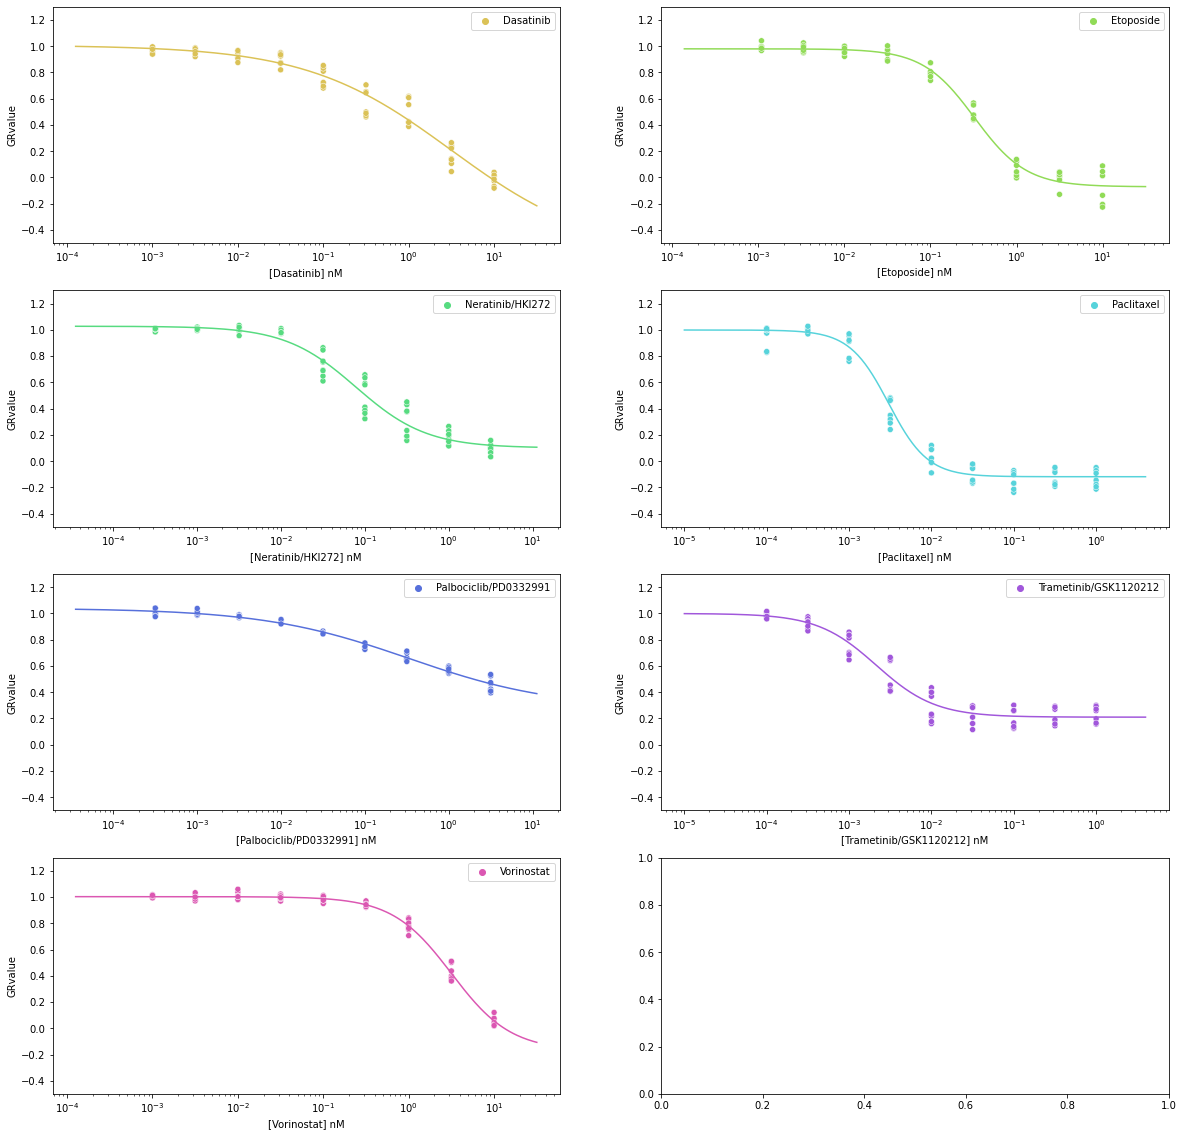

In [45]:

fig, ax = plt.subplots(math.ceil(len(agents)/2), 2, figsize=(20, 5*math.ceil(len(agents)/2))) 
for agent, subplot in zip(agents, ax.flatten()):
    
    data_SM_i = data_clean[data_clean['agent'] == agent]
    data_SM_i['logDose'] = -np.log10(1e-6*(data_SM_i.concentration))
    refDose = np.linspace(min(data_SM_i.logDose)*0.9,max(data_SM_i.logDose)*1.1,256) 
    refDose = (10**-refDose)*1e6
    
    sns.scatterplot('concentration', 'GRvalue',
                    ax = subplot,
                    data= data_SM_i,
                    hue='agent',
                    palette = colors).set(ylabel = 'GRvalue', 
                                          xlabel = ('[' + agent + '] nM'))
    
    fit_CL = next(c for c in fitData if c["agent"] == agent)
    sns.lineplot([i for i in refDose],
                 [ll4(i, * [fit_CL[i] for i in ['b', 'c', 'd', 'e']]) for i in refDose],
                      ax = subplot,
                      color = colors.get(agent)).set(ylabel = 'GRvalue', 
                                                    xlabel = ('[' + agent + '] nM'))
    
    subplot.set(xscale="log", 
                ylim = (-0.5, 1.3))